# Proyecto Final MAT281: Sistemas Recomendadores

**Integrantes:**

1- Matías Barra

2- José Cea

3- Cristóbal Lobos

4- Maryon Morales

5- Ana/Javiera Moreno

**Fecha:** 28/12/2021

**Profesor:** Francisco Alfaro


Usando la base de datos de Netflix, Inc., se busca implementar un sistema recomendador de películas y/o series.

La base está actualizada hasta Diciembre 2021 (se actualiza cada mes), y posee varios datos sobre una película/serie, tales como título (title), reparto (cast), el país de origen (country), entre otros.

La base se encuentra en https://www.kaggle.com/shivamb/netflix-shows/tasks.

Para hacer el sistema, la idea es hacer procesamiento de texto de las columnas de texto para vectorizarlas y de esta manera trabajar con herramientas de comparación de vectores.

##Librerías 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
from time import time
import statistics as sta
import warnings


import nltk
from nltk.corpus import stopwords
warnings.filterwarnings("ignore")

## Leer datos y preprocesamiento

In [ ]:
#Lectura de datos
netflix = pd.read_csv('netflix_titles.csv',sep=',') 
netflix.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [ ]:
netflix.isnull().sum() #Datos faltantes por columna

show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64

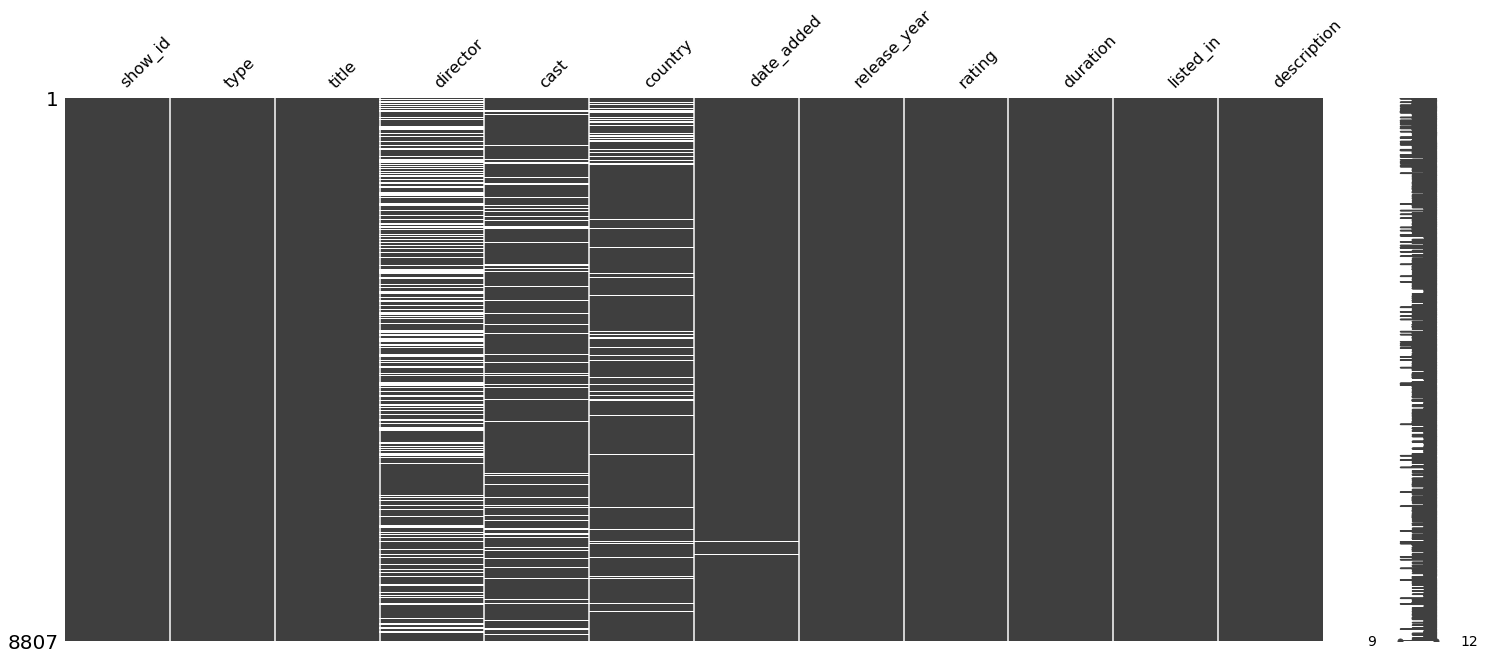

In [ ]:
import missingno as msno #Visualización de datos NaN

msno.matrix(netflix)

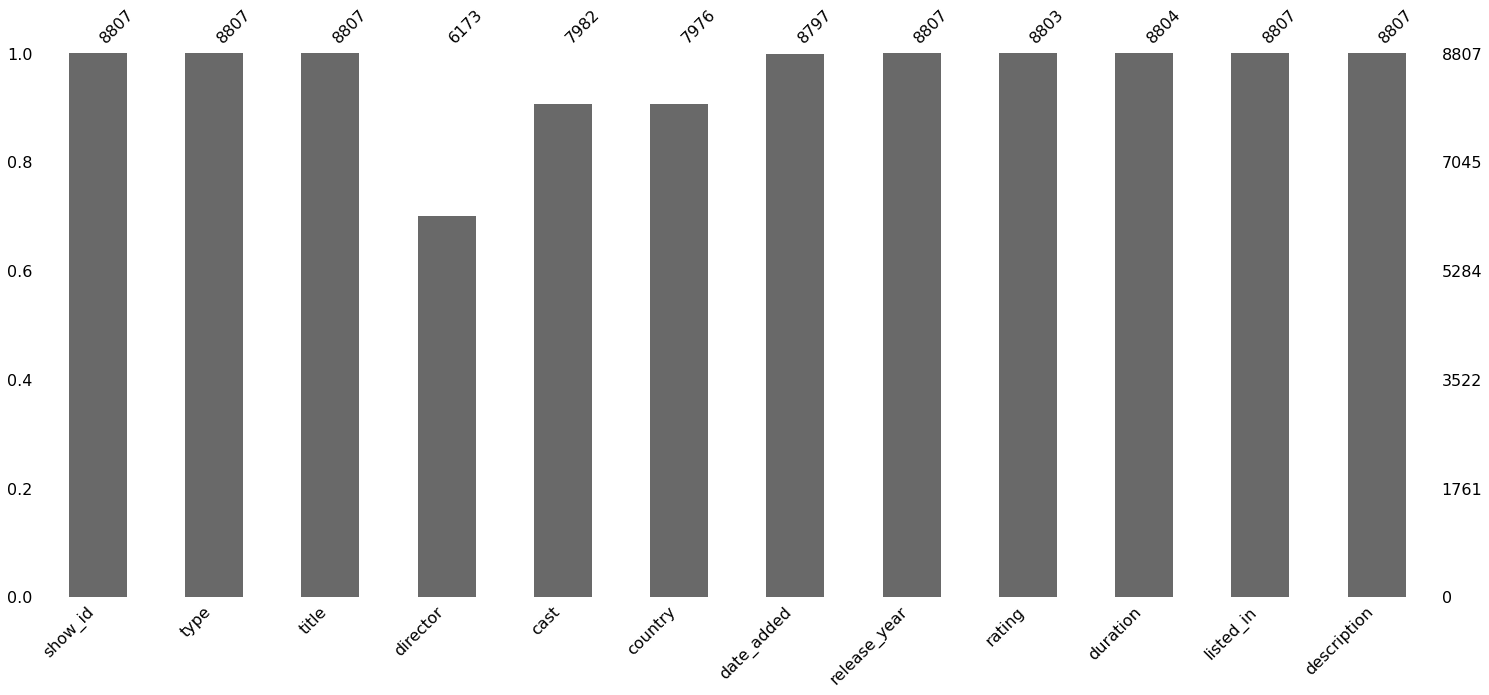

In [ ]:
msno.bar(netflix)

In [ ]:
netflix.info(memory_usage="deep") #Memoria

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 8.5 MB


In [ ]:
np.sort(netflix["release_year"].unique())

array([1925, 1942, 1943, 1944, 1945, 1946, 1947, 1954, 1955, 1956, 1958,
       1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969,
       1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980,
       1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991,
       1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002,
       2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
       2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021])

In [ ]:
netflix['rating'].unique()

array(['PG-13', 'TV-MA', 'PG', 'TV-14', 'TV-PG', 'TV-Y', 'TV-Y7', 'R',
       'TV-G', 'G', 'NC-17', '74 min', '84 min', '66 min', 'NR', nan,
       'TV-Y7-FV', 'UR'], dtype=object)

In [ ]:
netflix['type'].unique()

array(['Movie', 'TV Show'], dtype=object)

In [ ]:
netflix = netflix.fillna('') #Rellenamos todos los datos faltantes con un espacio por simplicidad para trabajar con texto

In [ ]:
netflix.isnull().sum() #Verificación de que no hay datos faltantes

show_id         0
type            0
title           0
director        0
cast            0
country         0
date_added      0
release_year    0
rating          0
duration        0
listed_in       0
description     0
dtype: int64

In [ ]:
netflix["date_added"] = pd.to_datetime(netflix['date_added']) #Transformación de la fecha para analizarla

netflix['year_added'] = netflix['date_added'].dt.year #Año de adición
netflix['month_added'] = netflix['date_added'].dt.month #Mes de adición

netflix['season_count'] = netflix.apply(lambda x : x['duration'].split(" ")[0] if "Season" in x['duration'] else "", axis = 1) #Número de temporadas si es una serie
netflix['duration'] = netflix.apply(lambda x : x['duration'].split(" ")[0] if "Season" not in x['duration'] else "", axis = 1) #Duración en minutos si es una película
netflix.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year_added,month_added,season_count
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,,United States,2021-09-25,2020,PG-13,90,Documentaries,"As her father nears the end of his life, filmm...",2021.0,9.0,
1,s2,TV Show,Blood & Water,,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021-09-24,2021,TV-MA,,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",2021.0,9.0,2
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",,2021-09-24,2021,TV-MA,,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,2021.0,9.0,1
3,s4,TV Show,Jailbirds New Orleans,,,,2021-09-24,2021,TV-MA,,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo...",2021.0,9.0,1
4,s5,TV Show,Kota Factory,,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,2021-09-24,2021,TV-MA,,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...,2021.0,9.0,2


## Análisis Exploratorio

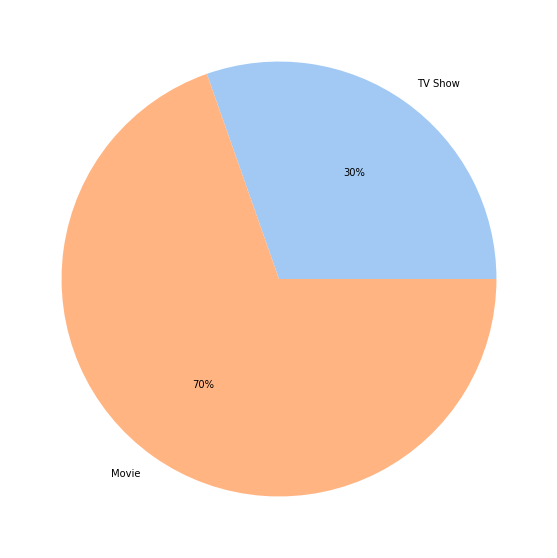

In [ ]:
data = [netflix[netflix['type']=='TV Show'].count()[0] , netflix[netflix['type']=='Movie'].count()[0]]
labels = ['TV Show', 'Movie']

colors = sns.color_palette('pastel')[0:5]

plt.figure(figsize=(10,10))
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

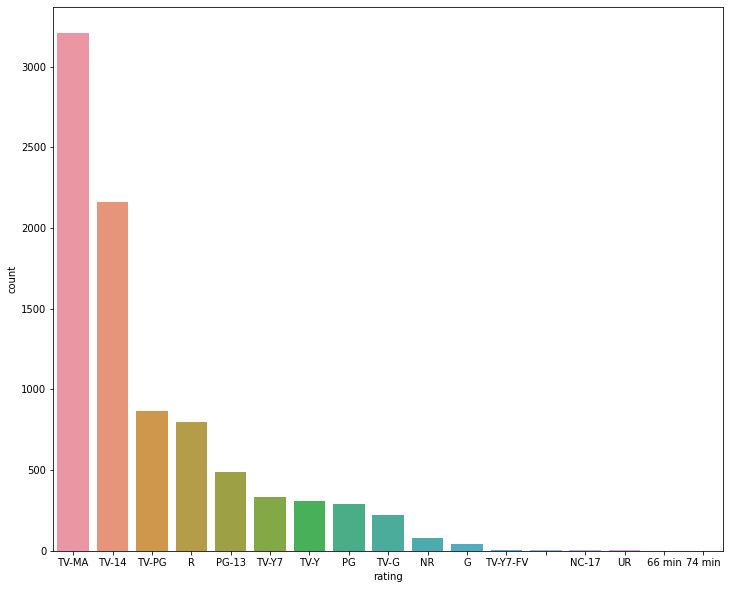

In [ ]:
#Cantidad de peliculas clasificadas por su rating

plt.figure(figsize=(12,10))
ax = sns.countplot(x="rating", data=netflix, order=netflix['rating'].value_counts().index[0:17])

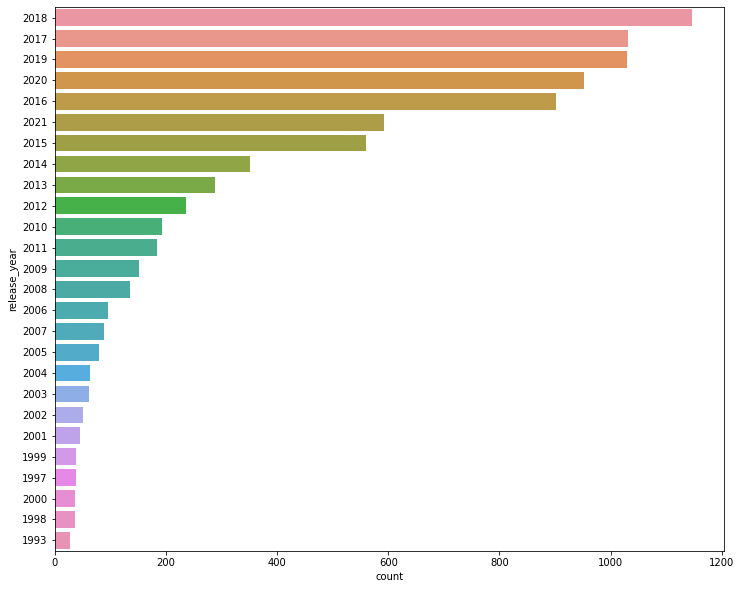

In [ ]:
#Año de estreno de películas/series

plt.figure(figsize=(12,10))
ax = sns.countplot(y="release_year", data=netflix, order=netflix['release_year'].value_counts().index[0:26])

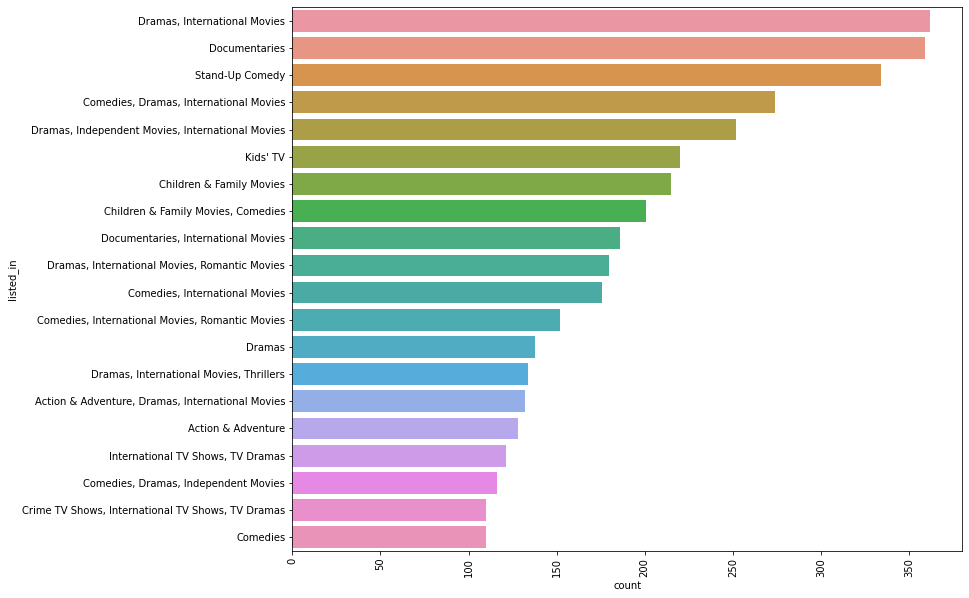

In [ ]:
#Cantidad de películas/series clasificadas por tipo

plt.figure(figsize=(12,10) )
plt.xticks(rotation=90)
ax = sns.countplot(y="listed_in", data=netflix, order=netflix['listed_in'].value_counts().index[0:20])

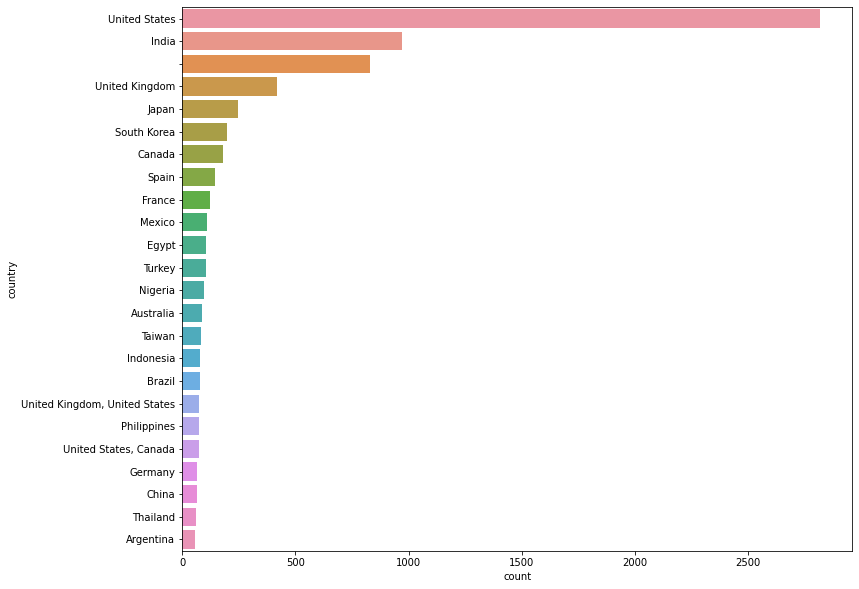

In [ ]:
#Cantidad películas por país de origen
plt.figure(figsize=(12,10))
ax = sns.countplot(y="country", data=netflix, order=netflix['country'].value_counts().index[0:24])

In [ ]:
##Cantidad de peliculas/series agregadas cada año

d1 = netflix[netflix["type"] == "TV Show"]
d2 = netflix[netflix["type"] == "Movie"]

col = "year_added"

vc1 = d1[col].value_counts().reset_index()
vc1 = vc1.rename(columns = {col : "count", "index" : col})
vc1['percent'] = vc1['count'].apply(lambda x : 100*x/sum(vc1['count']))
vc1 = vc1.sort_values(col)

vc2 = d2[col].value_counts().reset_index()
vc2 = vc2.rename(columns = {col : "count", "index" : col})
vc2['percent'] = vc2['count'].apply(lambda x : 100*x/sum(vc2['count']))
vc2 = vc2.sort_values(col)

trace1 = go.Scatter(x=vc1[col], y=vc1["count"], name="TV Shows", marker=dict(color="#a678de"))
trace2 = go.Scatter(x=vc2[col], y=vc2["count"], name="Movies", marker=dict(color="#6ad49b"))
data = [trace1, trace2]
layout = go.Layout(title="Contenido agregado a lo largo de los años", legend=dict(x=0.1, y=1.1, orientation="h"),
                   xaxis=dict(
          title="Años"
          ),
          yaxis=dict(
          title="Cantidad agregada"
          ))

fig = go.Figure(data, layout=layout)
fig.show()

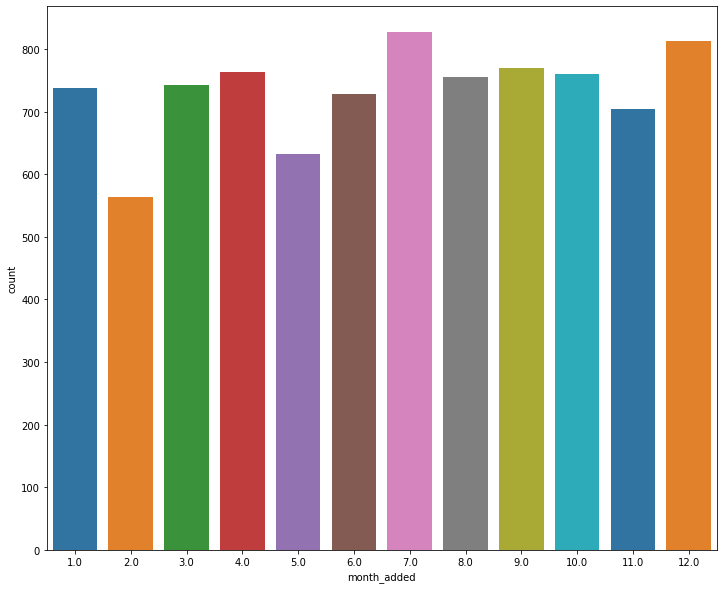

In [ ]:
#Análisis tipo de películas/series
plt.figure(figsize=(12,10))
plt.xticks(rotation=0)
sns.countplot(x="month_added", data=netflix, palette = 'tab10')

**Observaciones:**

-Debido al desbalance notable, y a lo que en general se busca al ver una nueva película, no se considerarán las fechas de adición ni de estreno para el sistema recomendador, por lo que solo se trabajará con texto.

-Ya que prácticamente sólo se tienen variables categóricas, se requiere convertir los datos a un tipo de dato numérico para poder realizar el análisis. Se podría usar **get_dummies** como en el curso cuando se estudarion casos con variables numéricas y pocas categóricas, en nuestro caso se utilizará la técnica de vectorización con las funciones **CountVectorizer** y **TfidVectorizer**.

## Funciones de texto

In [ ]:
from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer
from string import digits
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize,pos_tag

#|-------------------------------------O--------------------------------------------------------------|
#|-------------------------------------O--------------------------------------------------------------|

#                           FUNCIONES PARA PROCESAR EL TEXTO

#UTILIZACION: Se utiliza mediante dataframes, se trabaja con tokens (las cuales son listas de palabras)

#|-------------------------------------O--------------------------------------------------------------|
#|-------------------------------------O--------------------------------------------------------------|

def remove_whitespace(text): #funcion  para remover espacios innecesarios
    return  " ".join(text.split())

#|-------------------------------------O--------------------------------------------------------------|
#|-------------------------------------O--------------------------------------------------------------|

def remove_stopwords(text): ###Saca las stopwors de la lista de stop_words en ingles
    result = []
    for token in text:
        if token not in stop_words:
            result.append(token)
    return result

#|-------------------------------------O--------------------------------------------------------------|
#|-------------------------------------O--------------------------------------------------------------|
def remove_punct(text): ####Quita la puntuacion (puntos, guiones, etc)
    
    tokenizer = RegexpTokenizer(r"\w+")
    lst=tokenizer.tokenize(' '.join(text))
    return lst
#|-------------------------------------O--------------------------------------------------------------|
#|-------------------------------------O--------------------------------------------------------------|

In [ ]:

def remove_digit(text):  #####sacar digitos de las palabras
    result = []
    for token in text:
        remove_digits = str.maketrans('', '', digits)
        res = token.translate(remove_digits)
        result.append(res)
    return result

#|-------------------------------------O--------------------------------------------------------------|
#|-------------------------------------O--------------------------------------------------------------|

def lemmatization(text): #lematizacion
    
    result=[]
    wordnet = WordNetLemmatizer()
    for token,tag in pos_tag(text):
        pos=tag[0].lower()
        
        if pos not in ['a', 'r', 'n', 'v']:
            pos='n'
            
        result.append(wordnet.lemmatize(token,pos))
    
    return result

#|-------------------------------------O--------------------------------------------------------------|
#|-------------------------------------O--------------------------------------------------------------|

def removal(token): #Remueve palabras de largo menor a remove_number definido en la funcion
    token_final = []
    remove_number = 1
    for word in token:
        if len(word) > remove_number:
            token_final.append(word)
    return token_final

In [ ]:
def procesador(data, name): #recibe un dataframe df y el nombre de la columna que se desea procesar
    data_col = data[[name]]
    
    data_col[name] = data_col[name].str.lower()

    data[name] = data[name].apply(remove_whitespace) #espacios innecesarios
    
    data_col[name]= data_col[name].apply(lambda X: word_tokenize(X)) #TOKENIZACION
    
    data_col[name] = data_col[name].apply(lemmatization) #Lemmatizacion

    data_col[name] = data_col[name].apply(remove_stopwords) #stopwords, deben estar definidas anterior a aplicar la funcion
    
    data_col[name] = data_col[name].apply(remove_punct) #quita la puntuacion
    
    data_col[name] = data_col[name].apply(remove_digit) #quita los digitos de las palabras
    
    data_col[name] = data_col[name].apply(removal) #quitar palabras de largo menor al definido en la funcion
    
    return data_col #Retorna un dataframe con las palabras tokenizadas

In [ ]:
#Descarga de palabras para el funcionamiento correcto del procesador
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')
print()
stop_words = stopwords.words('english') 
new_words = ['(',')','1','2','3','4','5','6','7','8','9','0', '()','|']
for i in new_words:
  stop_words.append(i)
print(stop_words)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'th

## Acercamiento mediante CountVectorizer

### Procesamiento de Texto Usando solo título y descripción

In [ ]:
features = ['title', 'description'] #Atributos para usar en la recomendación
netflix_2 = netflix[features] #Dataframe a trabajar para el procesamiento

for i in features:
  netflix_2[i] = procesador(netflix_2,i)

In [ ]:
netflix_2.head()

,title,description
0,"[dick, johnson, dead]","[father, near, end, life, filmmaker, kirsten, ..."
1,"[blood, water]","[cross, path, party, cape, town, teen, set, pr..."
2,[gangland],"[protect, family, powerful, drug, lord, skille..."
3,"[jailbird, new, orleans]","[feud, flirtation, toilet, talk, go, among, in..."
4,"[kota, factory]","[city, coach, center, know, train, india, fine..."


In [ ]:
netflix_2['soup'] = netflix_2.sum(axis=1)

In [ ]:
def clean_data(x): #Junta todas las palabras del titulo 
        return str.lower(x.replace(" ", ""))

netflix_2['title_2'] = netflix['title'].apply(clean_data)

**CountVectorizer:**

(Explicar que es y que hace)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

def dummy(doc): #Se crea ya que las palabras ya están tokenizadas por el procesador
    return doc

vectorizer = CountVectorizer(tokenizer= dummy,
        preprocessor= dummy, binary=False, max_df = 0.4)


##EXPLICAR QUE ES CADA COSA

#Tokenizer
#Preprocessor
#max_df

count_matrix = vectorizer.fit_transform(netflix_2['soup']) #Vectorizar la matriz de features

count_matrix

<8807x18952 sparse matrix of type '<class 'numpy.int64'>'
	with 143137 stored elements in Compressed Sparse Row format>

## Métricas y función de recomendación

**Métricas a usar para comparar:**

-Coseno Similitud

-Euclideana

-Sigmoide???

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity 
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import sigmoid_kernel

sigmoid = sigmoid_kernel(count_matrix, count_matrix) #producto punto
cos_sim = cosine_similarity(count_matrix, count_matrix) #coseno similarid
euclidean = euclidean_distances(count_matrix, count_matrix) #metrica euclideana

In [ ]:
netflix_2 = netflix_2.reset_index()
indices = pd.Series(netflix_2.index, index=netflix_2['title_2'])

In [ ]:
def get_recommendation_cos(title, metric):
    title=title.replace(' ','').lower()
    idx = indices[title]

    # Similaridad utilizando la metrica dada de todas las peliculas con respecto a la ingresada
    sim_scores = list(enumerate(metric[idx]))

    # Ordenar de mayor a menor

    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse = True)

    # Primeros 10 puntajes
    
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    recomendations = netflix['title'].iloc[movie_indices]

    df_out = pd.DataFrame(list(zip(recomendations,[x[1] for x in sim_scores])), columns=['Recomendaciones','Puntaje'], index = movie_indices)  
    # Return the top 10 most similar movies
    return df_out

In [ ]:
def get_recommendation_dis(title, metric):
    title=title.replace(' ','').lower()
    idx = indices[title]

    # Similaridad utilizando la metrica dada de todas las peliculas con respecto a la ingresada
    sim_scores = list(enumerate(metric[idx]))

    # Ordenar de mayor a menor

    sim_scores = sorted(sim_scores, key=lambda x: x[1])

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    recomendations = netflix['title'].iloc[movie_indices]

    df_out = pd.DataFrame(list(zip(recomendations,[x[1] for x in sim_scores])), columns=['Recomendaciones','Puntaje'], index = movie_indices)  
    # Return the top 10 most similar movies
    return df_out

In [ ]:
recomendacion_c_sigmoid_t = get_recommendation_cos('Narcos', sigmoid) 
recomendacion_c_cos_t = get_recommendation_cos('Narcos', cos_sim)
recomendacion_c_euc_t = get_recommendation_dis('Narcos', euclidean)

### Procesamiento de texto usando varios atributos

In [ ]:
features = ['title', 'description', 'cast', 'listed_in', 'country'] #Atributos para usar en la recomendación
netflix_2 = netflix[features] #Dataframe a trabajar para el procesamiento

for i in features:
  netflix_2[i] = procesador(netflix_2,i)

In [ ]:
netflix_2.head()

,title,description,cast,listed_in,country
0,"[dick, johnson, dead]","[father, near, end, life, filmmaker, kirsten, ...",[],[documentary],"[united, state]"
1,"[blood, water]","[cross, path, party, cape, town, teen, set, pr...","[ama, qamata, khosi, ngema, gail, mabalane, th...","[international, tv, show, tv, drama, tv, mystery]","[south, africa]"
2,[gangland],"[protect, family, powerful, drug, lord, skille...","[sami, bouajila, tracy, gotoas, samuel, jouy, ...","[crime, tv, show, international, tv, show, tv,...",[]
3,"[jailbird, new, orleans]","[feud, flirtation, toilet, talk, go, among, in...",[],"[docuseries, reality, tv]",[]
4,"[kota, factory]","[city, coach, center, know, train, india, fine...","[mayur, jitendra, kumar, ranjan, raj, alam, kh...","[international, tv, show, romantic, tv, show, ...",[india]


In [ ]:
netflix_2['soup'] = netflix_2.sum(axis=1)

In [ ]:
def clean_data(x): #Junta todas las palabras del titulo 
        return str.lower(x.replace(" ", ""))

netflix_2['title_2'] = netflix['title'].apply(clean_data)

**CountVectorizer:**

(Explicar que es y que hace)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

def dummy(doc): #Se crea ya que las palabras ya están tokenizadas por el procesador
    return doc

vectorizer = CountVectorizer(tokenizer= dummy,
        preprocessor= dummy, binary=False, max_df = 0.4)


##EXPLICAR QUE ES CADA COSA

#Tokenizer
#Preprocessor
#max_df

count_matrix = vectorizer.fit_transform(netflix_2['soup']) #Vectorizar la matriz de features

count_matrix

<8807x46615 sparse matrix of type '<class 'numpy.int64'>'
	with 299814 stored elements in Compressed Sparse Row format>

### Recomendación

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity 
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import sigmoid_kernel

sigmoid = sigmoid_kernel(count_matrix, count_matrix) #producto punto
cos_sim = cosine_similarity(count_matrix, count_matrix) #coseno similarid
euclidean = euclidean_distances(count_matrix, count_matrix) #metrica euclideana

In [ ]:
netflix_2 = netflix_2.reset_index()
indices = pd.Series(netflix_2.index, index=netflix_2['title_2'])

In [ ]:
recomendacion_c_sigmoid_v = get_recommendation_cos('Narcos', sigmoid) 
recomendacion_c_cos_v = get_recommendation_cos('Narcos', cos_sim)
recomendacion_c_euc_v = get_recommendation_dis('Narcos ', euclidean)

## Acercamiento mediante TfidfVectorizer

### Procesamiento de Texto Usando solo título y descripción

In [ ]:
features = ['title', 'description'] #Atributos para usar en la recomendación
netflix_2 = netflix[features] #Dataframe a trabajar para el procesamiento

for i in features:
  netflix_2[i] = procesador(netflix_2,i)

In [ ]:
netflix_2.head()

,title,description
0,"[dick, johnson, dead]","[father, near, end, life, filmmaker, kirsten, ..."
1,"[blood, water]","[cross, path, party, cape, town, teen, set, pr..."
2,[gangland],"[protect, family, powerful, drug, lord, skille..."
3,"[jailbird, new, orleans]","[feud, flirtation, toilet, talk, go, among, in..."
4,"[kota, factory]","[city, coach, center, know, train, india, fine..."


In [ ]:
netflix_2['soup'] = netflix_2.sum(axis=1)

In [ ]:
def clean_data(x): #Junta todas las palabras del titulo 
        return str.lower(x.replace(" ", ""))

netflix_2['title_2'] = netflix['title'].apply(clean_data)

**TfidfVectorizer:**

La puntuación **TF-IDF** (Term Frequency-Inverse Document Frequency) es la frecuencia de apariciones de una palabra en un documento, pero dando una menor menor ponderación a las 'palabras de parada' que corresponden a palabras funcionales como conectores o adverbios (por ejemplo en Inglés: palabras del tipo "the","a","i","how","what"), así se evita que los términos menos significativos dominen el análisis estadístico. 

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

def dummy(doc): #Se crea ya que las palabras ya están tokenizadas por el procesador
    return doc

vectorizer = TfidfVectorizer(tokenizer= dummy,
        preprocessor= dummy, binary=False, max_df = 0.4)


##EXPLICAR QUE ES CADA COSA

#Tokenizer
#Preprocessor
#max_df

count_matrix = vectorizer.fit_transform(netflix_2['soup']) #Vectorizar la matriz de features

count_matrix

<8807x18952 sparse matrix of type '<class 'numpy.float64'>'
	with 143137 stored elements in Compressed Sparse Row format>

### Recomendación

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity 
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import sigmoid_kernel

sigmoid = sigmoid_kernel(count_matrix, count_matrix) #producto punto
cos_sim = cosine_similarity(count_matrix, count_matrix) #coseno similarid
euclidean = euclidean_distances(count_matrix, count_matrix) #metrica euclideana

In [ ]:
netflix_2 = netflix_2.reset_index()
indices = pd.Series(netflix_2.index, index=netflix_2['title_2'])

In [ ]:
recomendacion_t_sigmoid_t = get_recommendation_cos('Narcos', sigmoid) 
recomendacion_t_cos_t = get_recommendation_cos('Narcos', cos_sim)
recomendacion_t_euc_t = get_recommendation_dis('Narcos', euclidean)

### Procesamiento de texto usando varios atributos

In [ ]:
features = ['title', 'description', 'cast', 'listed_in', 'country'] #Atributos para usar en la recomendación
netflix_2 = netflix[features] #Dataframe a trabajar para el procesamiento

for i in features:
  netflix_2[i] = procesador(netflix_2,i)

In [ ]:
netflix_2.head()

,title,description,cast,listed_in,country
0,"[dick, johnson, dead]","[father, near, end, life, filmmaker, kirsten, ...",[],[documentary],"[united, state]"
1,"[blood, water]","[cross, path, party, cape, town, teen, set, pr...","[ama, qamata, khosi, ngema, gail, mabalane, th...","[international, tv, show, tv, drama, tv, mystery]","[south, africa]"
2,[gangland],"[protect, family, powerful, drug, lord, skille...","[sami, bouajila, tracy, gotoas, samuel, jouy, ...","[crime, tv, show, international, tv, show, tv,...",[]
3,"[jailbird, new, orleans]","[feud, flirtation, toilet, talk, go, among, in...",[],"[docuseries, reality, tv]",[]
4,"[kota, factory]","[city, coach, center, know, train, india, fine...","[mayur, jitendra, kumar, ranjan, raj, alam, kh...","[international, tv, show, romantic, tv, show, ...",[india]


In [ ]:
netflix_2['soup'] = netflix_2.sum(axis=1)

In [ ]:
def clean_data(x): #Junta todas las palabras del titulo 
        return str.lower(x.replace(" ", ""))

netflix_2['title_2'] = netflix['title'].apply(clean_data)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

def dummy(doc): #Se crea ya que las palabras ya están tokenizadas por el procesador
    return doc

vectorizer = TfidfVectorizer(tokenizer= dummy,
        preprocessor= dummy, binary=False, max_df = 0.4)


##EXPLICAR QUE ES CADA COSA

#Tokenizer
#Preprocessor
#max_df

count_matrix = vectorizer.fit_transform(netflix_2['soup']) #Vectorizar la matriz de features

count_matrix

<8807x46615 sparse matrix of type '<class 'numpy.float64'>'
	with 299814 stored elements in Compressed Sparse Row format>

### Recomendación

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity 
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import sigmoid_kernel

sigmoid = sigmoid_kernel(count_matrix, count_matrix) #producto punto
cos_sim = cosine_similarity(count_matrix, count_matrix) #coseno similarid
euclidean = euclidean_distances(count_matrix, count_matrix) #metrica euclideana

In [ ]:
netflix_2 = netflix_2.reset_index()
indices = pd.Series(netflix_2.index, index=netflix_2['title_2'])

In [ ]:
recomendacion_t_sigmoid_v = get_recommendation_cos('Narcos', sigmoid) 
recomendacion_t_cos_v = get_recommendation_cos('Narcos', cos_sim)
recomendacion_t_euc_v = get_recommendation_dis('Narcos', euclidean)

## Visualización resultados

In [ ]:
# Resetear indices para juntar todo y visualizar resultados

recomendacion_c_sigmoid_v = recomendacion_c_sigmoid_v.reset_index()
recomendacion_c_cos_v = recomendacion_c_cos_v.reset_index()
recomendacion_c_euc_v = recomendacion_c_euc_v.reset_index()

recomendacion_c_sigmoid_t = recomendacion_c_sigmoid_t.reset_index()
recomendacion_c_cos_t = recomendacion_c_cos_t.reset_index() 
recomendacion_c_euc_t = recomendacion_c_euc_t.reset_index()

recomendacion_t_sigmoid_t = recomendacion_t_sigmoid_t.reset_index()
recomendacion_t_cos_t = recomendacion_t_cos_t.reset_index()
recomendacion_t_euc_t = recomendacion_t_euc_t.reset_index()

recomendacion_t_sigmoid_v = recomendacion_t_sigmoid_v.reset_index()
recomendacion_t_cos_v = recomendacion_t_cos_v.reset_index()
recomendacion_t_euc_v = recomendacion_t_euc_v.reset_index()

In [ ]:
df_cos = pd.DataFrame(recomendacion_c_cos_t, columns = ['Recomendaciones'])
df_cos['Count Varios'] = recomendacion_c_cos_v['Recomendaciones']
df_cos['Tdif Titulo'] = recomendacion_t_cos_t['Recomendaciones']
df_cos['Tdif Varios'] = recomendacion_t_cos_v['Recomendaciones']
df_cos

,Recomendaciones,Count Varios,Tdif Titulo,Tdif Varios
0,Narcos: Mexico,Narcos: Mexico,Narcos: Mexico,Wild District
1,El Chapo,Wild District,El Cartel 2,El Cartel
2,Shiny_Flakes: The Teenage Drug Lord,El final del paraíso,Inside the Real Narcos,Narcos: Mexico
3,El Cartel 2,El Cartel,Miss Dynamite,El final del paraíso
4,El Cartel,Sin senos no hay paraíso,El Cartel,The Great Heist
5,Cocaine Cowboys: The Kings of Miami,The Great Heist,El final del paraíso,El Cartel 2
6,The Sky Is Pink,Luis Miguel - The Series,Somos.,Sin senos sí hay paraíso
7,Somos.,La Reina del Sur,Cocaine,La Reina del Sur
8,Christine,El Cartel 2,Shiny_Flakes: The Teenage Drug Lord,La Viuda Negra
9,Defiance,Sin senos sí hay paraíso,Street Flow,Dueños del paraíso


In [ ]:
cr=pd.concat([recomendacion_c_cos_v['Recomendaciones'],recomendacion_t_cos_t['Recomendaciones'],recomendacion_t_cos_v['Recomendaciones']]).to_frame()
cr

,Recomendaciones
0,Narcos: Mexico
1,Wild District
2,El final del paraíso
3,El Cartel
4,Sin senos no hay paraíso
5,The Great Heist
6,Luis Miguel - The Series
7,La Reina del Sur
8,El Cartel 2
9,Sin senos sí hay paraíso


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]), <a list of 18 Text major ticklabel objects>)

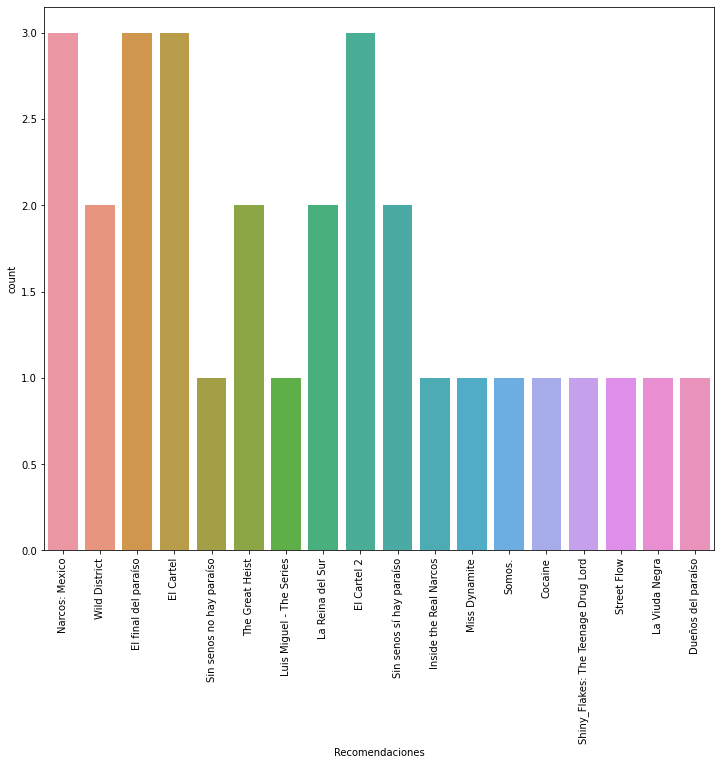

In [ ]:
plt.figure(figsize=(12,10))
ax = sns.countplot(x='Recomendaciones', data=cr)
plt.xticks(rotation=90)

In [ ]:
df_euc = pd.DataFrame(recomendacion_c_euc_t, columns = ['Recomendaciones'])
df_euc['Count Varios'] = recomendacion_c_euc_v['Recomendaciones']
df_euc['Tdif Titulo'] = recomendacion_t_euc_t['Recomendaciones']
df_euc['Tdif Varios'] = recomendacion_t_euc_v['Recomendaciones']
df_euc

,Recomendaciones,Count Varios,Tdif Titulo,Tdif Varios
0,Narcos: Mexico,Narcos: Mexico,Narcos: Mexico,Wild District
1,WHAT DID JACK DO?,Los tiempos de Pablo Escobar,El Cartel 2,El Cartel
2,Teresa,Dope,Inside the Real Narcos,Narcos: Mexico
3,Locombianos,Killer Ratings,Miss Dynamite,El final del paraíso
4,Classic Legends,The Bachelor,El Cartel,The Great Heist
5,The Sky Is Pink,Ajaibnya Cinta,El final del paraíso,El Cartel 2
6,Dope,WHAT DID JACK DO?,Somos.,Sin senos sí hay paraíso
7,Kazoops!,Drug Lords,Cocaine,La Reina del Sur
8,Goosebumps,The Staircase,Shiny_Flakes: The Teenage Drug Lord,La Viuda Negra
9,3 Deewarein,I AM A KILLER,Street Flow,Dueños del paraíso


In [ ]:
er=pd.concat([recomendacion_c_euc_v['Recomendaciones'],recomendacion_t_euc_t['Recomendaciones'],recomendacion_t_euc_v['Recomendaciones']]).to_frame()
er

,Recomendaciones
0,Narcos: Mexico
1,Los tiempos de Pablo Escobar
2,Dope
3,Killer Ratings
4,The Bachelor
5,Ajaibnya Cinta
6,WHAT DID JACK DO?
7,Drug Lords
8,The Staircase
9,I AM A KILLER


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 <a list of 25 Text major ticklabel objects>)

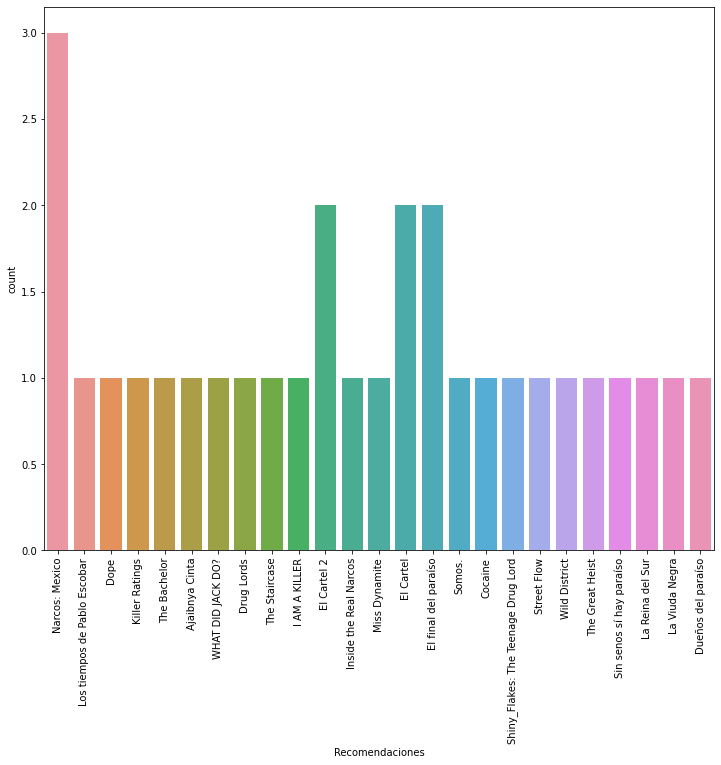

In [ ]:
plt.figure(figsize=(12,10))
ax = sns.countplot(x='Recomendaciones', data=er)
plt.xticks(rotation=90)

In [ ]:
df_sig = pd.DataFrame(recomendacion_c_sigmoid_t, columns = ['Recomendaciones'])
df_sig['Count Varios'] = recomendacion_c_sigmoid_v['Recomendaciones']
df_sig['Tdif Titulo'] = recomendacion_t_sigmoid_t['Recomendaciones']
df_sig['Tdif Varios'] = recomendacion_t_sigmoid_v['Recomendaciones']
df_sig

,Recomendaciones,Count Varios,Tdif Titulo,Tdif Varios
0,Narcos: Mexico,Sin senos sí hay paraíso,Narcos: Mexico,Wild District
1,Shiny_Flakes: The Teenage Drug Lord,Wild District,El Cartel 2,El Cartel
2,El Chapo,El final del paraíso,Inside the Real Narcos,Narcos: Mexico
3,Cocaine Cowboys: The Kings of Miami,Narcos: Mexico,Miss Dynamite,El final del paraíso
4,El Cartel,La Reina del Sur,El Cartel,The Great Heist
5,El Cartel 2,The Great Heist,El final del paraíso,El Cartel 2
6,Ganglands,Dueños del paraíso,Somos.,Sin senos sí hay paraíso
7,Shootout at Lokhandwala,El Cartel,Cocaine,La Reina del Sur
8,Seabiscuit,Her Mother's Killer,Shiny_Flakes: The Teenage Drug Lord,La Viuda Negra
9,Somos.,El Cartel 2,Street Flow,Dueños del paraíso


In [ ]:
sr=pd.concat([recomendacion_c_sigmoid_v['Recomendaciones'],recomendacion_t_sigmoid_t['Recomendaciones'],recomendacion_t_sigmoid_v['Recomendaciones']]).to_frame()
sr

,Recomendaciones
0,Sin senos sí hay paraíso
1,Wild District
2,El final del paraíso
3,Narcos: Mexico
4,La Reina del Sur
5,The Great Heist
6,Dueños del paraíso
7,El Cartel
8,Her Mother's Killer
9,El Cartel 2


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 <a list of 17 Text major ticklabel objects>)

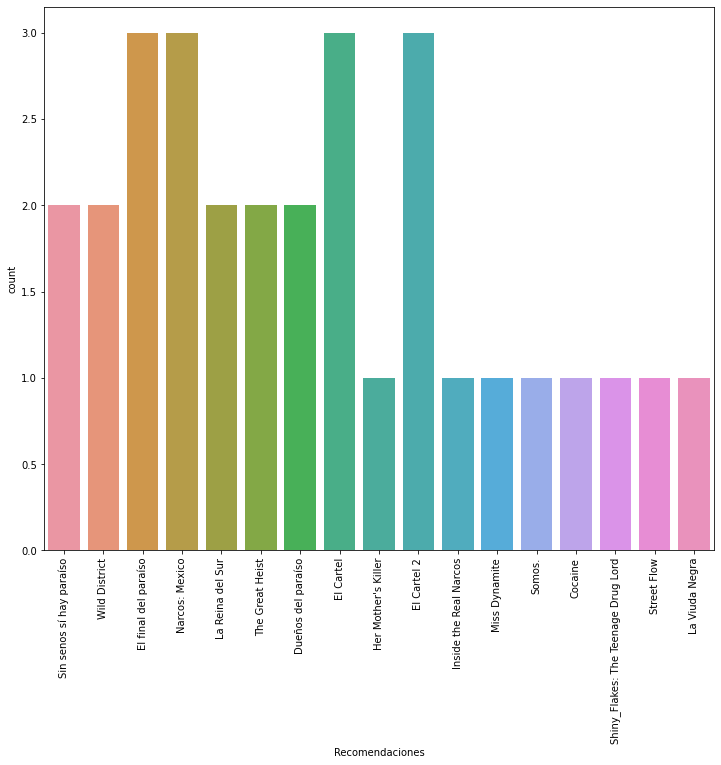

In [ ]:
plt.figure(figsize=(12,10))
ax = sns.countplot(x='Recomendaciones', data=sr)
plt.xticks(rotation=90)

## Conclusiones

Escribir